# Megaline. Análisis de Rentabilidad por Plan

Megaline ofrece a sus clientes dos tarifas de prepago, Surf y Ultimate. El departamento comercial quiere saber cuál de las tarifas genera más ingresos para poder ajustar el presupuesto de publicidad.

Base de datos de 500 clientes de Megaline en 2018
Objetivo: analizar el comportamiento de los clientes y determinar qué tarifa de prepago genera más ingresos.

## Introducción 


El objetivo de este proyecto es analizar el comportamiento de los clientes de Megaline que utilizan las tarifas de prepago Surf y Ultimate, con el fin de determinar cuál de estas dos tarifas genera más ingresos. Esta información permitirá ajustar la estrategia de publicidad y enfocarse en los planes que resulten más rentables para la empresa.


Para alcanzar este objetivo, planeo realizar las siguientes acciones:

1.	Explorar y revisar los conjuntos de datos para identificar valores faltantes, duplicados o inconsistencias, y asegurarme de que los tipos de datos sean correctos (por ejemplo, fechas como datetime y números como int o float).
2.	Calcular el consumo mensual por cliente:
A partir de la información de llamadas, mensajes y consumo de internet por usuario y por mes.
3.	Calcular los  ingresos mensuales:
Combinar la información de consumo con los planes y sus tarifas para calcular los ingresos mensuales de cada cliente, incluyendo cargos fijos y posibles cargos por uso adicional.
4.	Análisis estadístico descriptivo:
De los ingresos, llamadas, mensajes y consumo de internet entre los usuarios de Surf y Ultimate, (media, mediana, desviación estándar) y visualizaciones como histogramas o boxplots.
5.	Prueba de hipótesis estadística:
Determinar si la diferencia de ingresos entre las dos tarifas es estadísticamente significativa mediante una prueba t de dos muestras independientes.
6.	Conclusiones y recomendaciones:
Presentar los resultados del análisis, indicando cuál plan es más rentable y sugiriendo posibles acciones para mejorar la rentabilidad de los planes 


## Inicialización

In [ ]:
# Cargar todas las librerías
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st


## Cargar datos

In [ ]:
# Carga los archivos de datos en diferentes DataFrames

plans = pd.read_csv('/datasets/megaline_plans.csv')
calls = pd.read_csv('/datasets/megaline_calls.csv')
internet = pd.read_csv('/datasets/megaline_internet.csv')
sms = pd.read_csv('/datasets/megaline_messages.csv')
users= pd.read_csv('/datasets/megaline_users.csv')


## Preparar los datos

## Tarifas

In [ ]:
# Imprime la información general/resumida sobre el DataFrame de las tarifas
print(plans.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes
None


In [ ]:
# Imprime una muestra de los datos para las tarifas
print(plans.head())
#print(plans['plan_name'].unique())

   messages_included  mb_per_month_included  minutes_included  \
0                 50                  15360               500   
1               1000                  30720              3000   

   usd_monthly_pay  usd_per_gb  usd_per_message  usd_per_minute plan_name  
0               20          10             0.03            0.03      surf  
1               70           7             0.01            0.01  ultimate  


Se puede observar que tenemos los datos correspondientes a dos planes, es decir solo hay dos filas, una por cada plan. No hay valores nulos o ausentes.  Casi todas las columnas son del tipo de datos int64 o enteros, excepto usd_per_message y usd_per_minute que corresponden al precio por minuto y por mensaje tras exceder el plan. Ambas columnas representan el precio en dolares (centavos de dolar) son float64 y considero deben quedarse de esa forma. Por último, aunque la columna plan_name  es de tipo object, lo cual aunque es apropiado para representar texto en pandas, considero se debería confirmar que es de tipo str.

## Corregir datos

In [ ]:
plans['plan_name']= plans['plan_name'].astype(str)
#print(plans.info())

## Enriquecer los datos

Si trabajaremos eventualmente con GB, conviene crear otra columna para tener directamente los GB.
También podriamos renombrar algunas columnas como usd_per_minute, usd_per_message y usd_per_gb para que sean más claros y hagan referencia al precio tras exceder los límites del paquete

In [ ]:
plans['gb_per_month_included'] = plans['mb_per_month_included'] / 1024
plans['gb_per_month_included'] = plans['gb_per_month_included'].astype(int)
plans= plans.rename(columns={'usd_per_minute': 'usd_per_extra_minute',
                             'usd_per_message':'usd_per_extra_sms',
                            'usd_per_gb':'usd_per_extra_gb'
                              })
#print(plans.info())
#print(plans.head())

## Usuarios/as

In [ ]:
# Imprime la información general/resumida sobre el DataFrame de usuarios
print(users.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
None


In [ ]:
# Imprime una muestra de datos para usuarios
print(users.head())
#print(users['plan'].unique())

   user_id first_name  last_name  age                                   city  \
0     1000   Anamaria      Bauer   45  Atlanta-Sandy Springs-Roswell, GA MSA   
1     1001     Mickey  Wilkerson   28        Seattle-Tacoma-Bellevue, WA MSA   
2     1002     Carlee    Hoffman   36   Las Vegas-Henderson-Paradise, NV MSA   
3     1003   Reynaldo    Jenkins   52                          Tulsa, OK MSA   
4     1004    Leonila   Thompson   40        Seattle-Tacoma-Bellevue, WA MSA   

     reg_date      plan churn_date  
0  2018-12-24  ultimate        NaN  
1  2018-08-13      surf        NaN  
2  2018-10-21      surf        NaN  
3  2018-01-28      surf        NaN  
4  2018-05-23      surf        NaN  


Para las columnas user_id (como identificador numérico), first_name, last_name, age,city y plan, no propongo algun cambio en el tipo de dato. Sin embargo, las columnas reg_date y churn_date que representan fechas, aparecen como object. Por lo que es recomendable convertirlas a tipo datetime para facilitar operaciones basadas en fechas. 

Solo en la columna churn_date tenemos 466 datos nulos o ausentes los cuales representan a los usuarios que no dejaron de usar el servicio. Y por lo tanto, deben conservarse los datos ya sea con NaNs o alguna etiqueta tipo 'usuario activo'.

Cambiar el nombre de la columna 'plan' a 'plan_name' o al revés para futuras comparaciones con merge, podría ser otro cambio.

### Corregir los datos

In [ ]:
users['reg_date']=pd.to_datetime(users['reg_date'])
users['churn_date']=pd.to_datetime(users['churn_date'])
users= users.rename(columns={'plan':'plan_name'})                        
#print(users.info())
#print(users.head())

### Enriquecer los datos

Mis propuestas son : 
Crear una columna nueva para hacer futuros filtros de usuarios activos y no activos o que dejaron de usar el servicio 
Crear otra columna con el tiempo en que estuvieron activos(cuantos días fue cliente cada usuario)

In [ ]:
users['is_active']= users['churn_date'].isna()
end_for_active_2018 = pd.Timestamp('2018-12-31')
users['end_date'] = users['churn_date'].fillna(end_for_active_2018)
users['days_ active']=(users['end_date']- users['reg_date']).dt.days 
print(users.head())
print(users.info())

   user_id first_name  last_name  age                                   city  \
0     1000   Anamaria      Bauer   45  Atlanta-Sandy Springs-Roswell, GA MSA   
1     1001     Mickey  Wilkerson   28        Seattle-Tacoma-Bellevue, WA MSA   
2     1002     Carlee    Hoffman   36   Las Vegas-Henderson-Paradise, NV MSA   
3     1003   Reynaldo    Jenkins   52                          Tulsa, OK MSA   
4     1004    Leonila   Thompson   40        Seattle-Tacoma-Bellevue, WA MSA   

    reg_date plan_name churn_date  is_active   end_date  days_ active  
0 2018-12-24  ultimate        NaT       True 2018-12-31             7  
1 2018-08-13      surf        NaT       True 2018-12-31           140  
2 2018-10-21      surf        NaT       True 2018-12-31            71  
3 2018-01-28      surf        NaT       True 2018-12-31           337  
4 2018-05-23      surf        NaT       True 2018-12-31           222  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (t

## Llamadas

In [ ]:
# Imprime la información general/resumida sobre el DataFrame de las llamadas
print(calls.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB
None


In [ ]:
# Imprime una muestra de datos para las llamadas
print(calls.head())

         id  user_id   call_date  duration
0   1000_93     1000  2018-12-27      8.52
1  1000_145     1000  2018-12-27     13.66
2  1000_247     1000  2018-12-27     14.48
3  1000_309     1000  2018-12-28      5.76
4  1000_380     1000  2018-12-30      4.22



Podemos observar que no tenemos datos nulos o ausentes. No propongo cambios en el tipo de datos para las columnas id, user_id y duration. Pero si para call_date  a tipo datetime.
El user_id como identificador numérico lo dejaremos en tipo int64 (aunque no se vaya a utilizar para operaciones matemáticas), solo para que coincida en nombre y tipo de dato con el user_id de las demás tablas. 


### Corregir los datos

In [ ]:
calls['call_date']=pd.to_datetime(calls['call_date'])
print(calls.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         137735 non-null  object        
 1   user_id    137735 non-null  int64         
 2   call_date  137735 non-null  datetime64[ns]
 3   duration   137735 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.2+ MB
None


### Enriquecer los datos

Mis propuestas son :
Crear columna donde se filtraran los datos por mes para posibles análisis futuros.
Crear otra columna para redondear la duración de las llamadas. Sabemos que Megaline redondea a 1 minuto entero aunque haya pasado 1 segundo. Y convertirla a tipo de datos int64


In [ ]:
calls['month']= calls['call_date'].dt.month

calls['duration_rounded'] = np.ceil(calls['duration']) #ceil para redondear hacia arriba
calls['duration_rounded'] =calls['duration_rounded'].astype(int)
print(calls.head())
print(calls.info())

         id  user_id  call_date  duration  month  duration_rounded
0   1000_93     1000 2018-12-27      8.52     12                 9
1  1000_145     1000 2018-12-27     13.66     12                14
2  1000_247     1000 2018-12-27     14.48     12                15
3  1000_309     1000 2018-12-28      5.76     12                 6
4  1000_380     1000 2018-12-30      4.22     12                 5
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   id                137735 non-null  object        
 1   user_id           137735 non-null  int64         
 2   call_date         137735 non-null  datetime64[ns]
 3   duration          137735 non-null  float64       
 4   month             137735 non-null  int64         
 5   duration_rounded  137735 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3),

## Mensajes

In [ ]:
# Imprime la información general/resumida sobre el DataFrame de los mensajes
print(sms.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB
None


In [ ]:
# Imprime una muestra de datos para los mensajes
print(sms.head())

         id  user_id message_date
0  1000_125     1000   2018-12-27
1  1000_160     1000   2018-12-31
2  1000_223     1000   2018-12-31
3  1000_251     1000   2018-12-27
4  1000_255     1000   2018-12-26


Como podemos observar, para la tabla de mensajes o sms, no hay datos ausentes. El tipo de datos para las columnas id y user_id deben mantenerse.Excepto para message_date que debe cambiarse a tipo datetime

### Corregir los datos

In [ ]:
sms['message_date']=pd.to_datetime(sms['message_date'])
print(sms.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            76051 non-null  object        
 1   user_id       76051 non-null  int64         
 2   message_date  76051 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.7+ MB
None


### Enriquecer los datos

Podemos crear nueva columna para extraer el mes 

In [ ]:
sms['month'] = sms['message_date'].dt.month
print(sms.head())

         id  user_id message_date  month
0  1000_125     1000   2018-12-27     12
1  1000_160     1000   2018-12-31     12
2  1000_223     1000   2018-12-31     12
3  1000_251     1000   2018-12-27     12
4  1000_255     1000   2018-12-26     12


## Internet

In [ ]:
# Imprime la información general/resumida sobre el DataFrame de internet
print(internet.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB
None


In [ ]:
# Imprime una muestra de datos para el tráfico de internet
print(internet.head())

         id  user_id session_date  mb_used
0   1000_13     1000   2018-12-29    89.86
1  1000_204     1000   2018-12-31     0.00
2  1000_379     1000   2018-12-28   660.40
3  1000_413     1000   2018-12-26   270.99
4  1000_442     1000   2018-12-27   880.22


Como se puede observar, esta tabla internet no tiene datos nulos o ausentes. En cuanto a el tipo de datos, solo cambiaría la columna session_date a tipo datetime. 

### Corregir los datos

In [ ]:
internet['session_date']=pd.to_datetime(internet['session_date'])

### Enriquecer los datos

Podría ser de utilidad crear una columna nueva de los gb_used en lugar de los mb_used SIN redondear ya que esto solo se aplica al total del mes no sobre cada sesión individual. 
Y también podria resultar útil crear otra columna donde se extrae el mes de session_date

In [ ]:
internet['month']= internet['session_date'].dt.month
internet['gb_used']= internet['mb_used'] / 1024
print(internet.info())
print(internet.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            104825 non-null  object        
 1   user_id       104825 non-null  int64         
 2   session_date  104825 non-null  datetime64[ns]
 3   mb_used       104825 non-null  float64       
 4   month         104825 non-null  int64         
 5   gb_used       104825 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(1)
memory usage: 4.8+ MB
None
         id  user_id session_date  mb_used  month   gb_used
0   1000_13     1000   2018-12-29    89.86     12  0.087754
1  1000_204     1000   2018-12-31     0.00     12  0.000000
2  1000_379     1000   2018-12-28   660.40     12  0.644922
3  1000_413     1000   2018-12-26   270.99     12  0.264639
4  1000_442     1000   2018-12-27   880.22     12  0.859590


## Estudiar las condiciones de las tarifas

Recordar : Megaline redondea los segundos a minutos y los megabytes a gigabytes. Para las llamadas, cada llamada individual se redondea: incluso si la llamada duró solo un segundo, se contará como un minuto. Para el tráfico web, las sesiones web individuales no se redondean. En vez de esto, el total del mes se redondea hacia arriba. Si alguien usa 1025 megabytes este mes, se le cobrarán 2 gigabytes.

In [ ]:
# Imprime las condiciones de la tarifa y asegúrate de que te quedan claras
print(plans.head())


   messages_included  mb_per_month_included  minutes_included  \
0                 50                  15360               500   
1               1000                  30720              3000   

   usd_monthly_pay  usd_per_extra_gb  usd_per_extra_sms  usd_per_extra_minute  \
0               20                10               0.03                  0.03   
1               70                 7               0.01                  0.01   

  plan_name  gb_per_month_included  
0      surf                     15  
1  ultimate                     30  


In [ ]:
# Calcula el número de llamadas hechas por cada usuario al mes. Guarda el resultado.
total_calls_per_user_month = calls.groupby(['user_id','month'])['id'].count().reset_index()
total_calls_per_user_month = total_calls_per_user_month.rename(columns={'id':'number_of_calls'})
print(total_calls_per_user_month.head(15))

    user_id  month  number_of_calls
0      1000     12               16
1      1001      8               27
2      1001      9               49
3      1001     10               65
4      1001     11               64
5      1001     12               56
6      1002     10               11
7      1002     11               55
8      1002     12               47
9      1003     12              149
10     1004      5               21
11     1004      6               44
12     1004      7               49
13     1004      8               49
14     1004      9               42


In [ ]:
# Calcula la cantidad de minutos usados por cada usuario al mes. Guarda el resultado.
total_minutes_per_user_month = calls.groupby(['user_id','month'])['duration_rounded'].sum().reset_index()
total_minutes_per_user_month = total_minutes_per_user_month.rename(columns={'duration_rounded':'total_minutes'})
print(total_minutes_per_user_month.head(15))

    user_id  month  total_minutes
0      1000     12            124
1      1001      8            182
2      1001      9            315
3      1001     10            393
4      1001     11            426
5      1001     12            412
6      1002     10             59
7      1002     11            386
8      1002     12            384
9      1003     12           1104
10     1004      5            193
11     1004      6            275
12     1004      7            381
13     1004      8            354
14     1004      9            301


In [ ]:
# Calcula el número de mensajes enviados por cada usuario al mes. Guarda el resultado.
total_sms_per_user_month = sms.groupby(['user_id','month'])['id'].count().reset_index()
total_sms_per_user_month = total_sms_per_user_month.rename(columns={'id':'total_sms'})
print(total_sms_per_user_month.head(15))

    user_id  month  total_sms
0      1000     12         11
1      1001      8         30
2      1001      9         44
3      1001     10         53
4      1001     11         36
5      1001     12         44
6      1002     10         15
7      1002     11         32
8      1002     12         41
9      1003     12         50
10     1004      5          7
11     1004      6         18
12     1004      7         26
13     1004      8         25
14     1004      9         21


In [ ]:
# Calcula el volumen del tráfico de Internet usado por cada usuario al mes. Guarda el resultado.
#print(internet.head(15))
total_gb_per_user_month = internet.groupby(['user_id','month'])['gb_used'].sum().reset_index()
total_gb_per_user_month = total_gb_per_user_month.rename(columns={'gb_used':'total_gb'})
total_gb_per_user_month['total_gb'] = np.ceil(total_gb_per_user_month['total_gb']) 
print(total_gb_per_user_month.head(15))

    user_id  month  total_gb
0      1000     12       2.0
1      1001      8       7.0
2      1001      9      14.0
3      1001     10      22.0
4      1001     11      19.0
5      1001     12      19.0
6      1002     10       7.0
7      1002     11      19.0
8      1002     12      15.0
9      1003     12      27.0
10     1004      5       7.0
11     1004      6      21.0
12     1004      7      24.0
13     1004      8      28.0
14     1004      9      19.0


In [ ]:

# Fusiona los datos de llamadas, minutos, mensajes e Internet con base en user_id y month

data_plan_users_month = total_calls_per_user_month.merge(total_minutes_per_user_month, on=['user_id','month'])
data_plan_users_month=data_plan_users_month.merge(total_sms_per_user_month,on=['user_id','month'])
data_plan_users_month=data_plan_users_month.merge(total_gb_per_user_month,on=['user_id','month'])
print(data_plan_users_month)


      user_id  month  number_of_calls  total_minutes  total_sms  total_gb
0        1000     12               16            124         11       2.0
1        1001      8               27            182         30       7.0
2        1001      9               49            315         44      14.0
3        1001     10               65            393         53      22.0
4        1001     11               64            426         36      19.0
...       ...    ...              ...            ...        ...       ...
1754     1496      9               52            414         21      17.0
1755     1496     10               46            317         18      14.0
1756     1496     11               39            308         13       9.0
1757     1496     12               40            294         11      17.0
1758     1497     12               54            300         50      11.0

[1759 rows x 6 columns]


In [ ]:
# Añade la información de la tarifa

#EXTRAER USER_ID and plan 
user_plan = users[['user_id','plan_name']]

#print(user_plan)
data_plan_users_month =data_plan_users_month.merge(user_plan,on=['user_id'])
print(data_plan_users_month.head(15))


    user_id  month  number_of_calls  total_minutes  total_sms  total_gb  \
0      1000     12               16            124         11       2.0   
1      1001      8               27            182         30       7.0   
2      1001      9               49            315         44      14.0   
3      1001     10               65            393         53      22.0   
4      1001     11               64            426         36      19.0   
5      1001     12               56            412         44      19.0   
6      1002     10               11             59         15       7.0   
7      1002     11               55            386         32      19.0   
8      1002     12               47            384         41      15.0   
9      1003     12              149           1104         50      27.0   
10     1004      5               21            193          7       7.0   
11     1004      6               44            275         18      21.0   
12     1004      7       

In [ ]:
# Calcula el ingreso mensual para cada usuario 1
data_plan_users_month= data_plan_users_month.merge(plans,on='plan_name',how='left')
# Minutos extras al plan
data_plan_users_month['extra_minutes']= data_plan_users_month['total_minutes'] - data_plan_users_month['minutes_included']
data_plan_users_month['extra_minutes']= data_plan_users_month['extra_minutes'].apply(lambda x: max(x,0))
# SMS extras al plan 
data_plan_users_month['extra_SMS']= data_plan_users_month['total_sms'] - data_plan_users_month['messages_included']
data_plan_users_month['extra_SMS']= data_plan_users_month['extra_SMS'].apply(lambda x: max(x,0))
# GB extras al plan 
data_plan_users_month['extra_GB']= data_plan_users_month['total_gb'] - data_plan_users_month['gb_per_month_included']
data_plan_users_month['extra_GB']= data_plan_users_month['extra_GB'].apply(lambda x: max(x,0))

print(data_plan_users_month)

      user_id  month  number_of_calls  total_minutes  total_sms  total_gb  \
0        1000     12               16            124         11       2.0   
1        1001      8               27            182         30       7.0   
2        1001      9               49            315         44      14.0   
3        1001     10               65            393         53      22.0   
4        1001     11               64            426         36      19.0   
...       ...    ...              ...            ...        ...       ...   
1754     1496      9               52            414         21      17.0   
1755     1496     10               46            317         18      14.0   
1756     1496     11               39            308         13       9.0   
1757     1496     12               40            294         11      17.0   
1758     1497     12               54            300         50      11.0   

     plan_name  messages_included  mb_per_month_included  minutes_included 

In [ ]:
# Calcula el ingreso mensual para cada usuario 2
#Calcular pagos extra 
data_plan_users_month['cost_extra_min'] = data_plan_users_month['extra_minutes'] * data_plan_users_month['usd_per_extra_minute']
data_plan_users_month['cost_extra_SMS'] = data_plan_users_month['extra_SMS'] * data_plan_users_month['usd_per_extra_sms'] 
data_plan_users_month['cost_extra_GB'] = data_plan_users_month['extra_GB'] * data_plan_users_month['usd_per_extra_gb'] 
#Calcular total a pagar o ingreso mensual para cada usuario
data_plan_users_month['total_payment_per_user'] = data_plan_users_month['usd_monthly_pay'] + data_plan_users_month['cost_extra_min']+ data_plan_users_month['cost_extra_SMS'] + data_plan_users_month['cost_extra_GB']   

print(data_plan_users_month[['user_id','month','plan_name','total_payment_per_user']].head(15))

    user_id  month plan_name  total_payment_per_user
0      1000     12  ultimate                   70.00
1      1001      8      surf                   20.00
2      1001      9      surf                   20.00
3      1001     10      surf                   90.09
4      1001     11      surf                   60.00
5      1001     12      surf                   60.00
6      1002     10      surf                   20.00
7      1002     11      surf                   60.00
8      1002     12      surf                   20.00
9      1003     12      surf                  158.12
10     1004      5      surf                   20.00
11     1004      6      surf                   80.00
12     1004      7      surf                  110.00
13     1004      8      surf                  150.00
14     1004      9      surf                   60.00


## Estudia el comportamiento de usuario


### Llamadas

plan_name      surf  ultimate
month                        
1          6.428000  6.541518
2          6.906175  6.517230
3          6.696919  6.210906
4          6.799918  6.659990
5          6.769200  6.662443
6          6.846812  6.705188
7          6.721710  6.879085
8          6.726164  6.613484
9          6.728684  6.770040
10         6.722302  6.665850
11         6.759115  6.742506
12         6.836607  6.671929


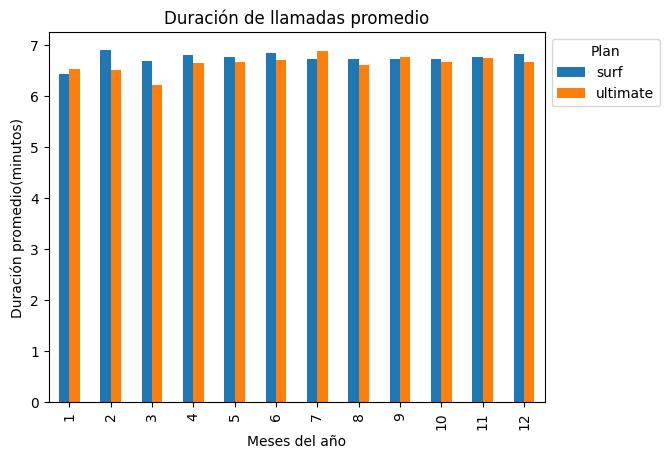

In [ ]:
# Compara la duración promedio de llamadas por cada plan y por cada mes. Traza un gráfico de barras para visualizarla. 
users_plan = users[['user_id','plan_name']]
calls2=calls.merge(users_plan,on='user_id',how='left')
#print(calls2.head(20))
#Promedio de la duración de llamadas por cada plan y por mes 
duration_calls_mean= calls2.groupby(['plan_name','month'])['duration'].mean().reset_index()
duration_calls_mean= duration_calls_mean.rename(columns={'duration':'duration_mean'})
#print(duration_calls_mean)
duration_calls_mean_pivot = duration_calls_mean.pivot(index= 'month',columns='plan_name',values='duration_mean')
print(duration_calls_mean_pivot)
ax = duration_calls_mean_pivot.plot(kind='bar',legend= True, xlabel ='Meses del año',
                               ylabel ='Duración promedio(minutos)',
                               title= 'Duración de llamadas promedio')
ax.legend(title='Plan', bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

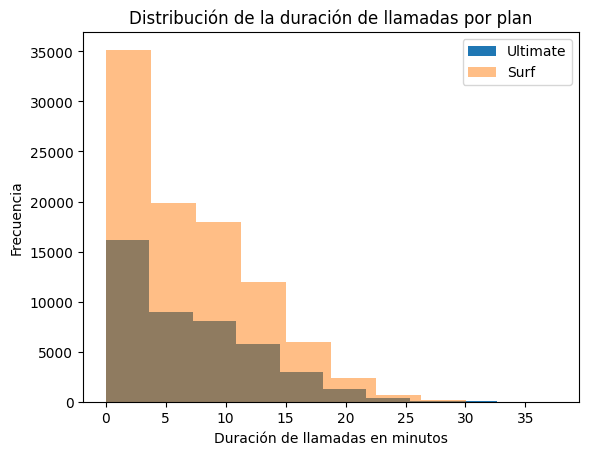

Promedio_duration_ calls_surf: 6.7672637217805365 Número de datos: 94084
Promedio_duration_calls_ultimate: 6.699938603926599 Número de datos: 43651


In [ ]:

# Compara el número de minutos mensuales que necesitan los usuarios de cada plan. Traza un histograma.
#calls2['duration'].plot(kind='hist', bins= 20)
#plt.xlabel('Duración de llamadas en minutos')
#plt.ylabel('Frecuencia')
#plt.title('Distribución de la duración de llamadas')
#plt.show()


#filtrar llamadas por plan 
calls_ultimate = calls2[calls2['plan_name'] == 'ultimate']['duration']
calls_surf = calls2[calls2['plan_name'] == 'surf']['duration']

#Distribucion de la duracion de llamadas por plan /tarifa
plt.hist(calls_ultimate, bins=10, alpha=1, label='Ultimate')
plt.hist(calls_surf, bins=10, alpha=0.5, label='Surf')

plt.xlabel('Duración de llamadas en minutos')
plt.ylabel('Frecuencia')
plt.title('Distribución de la duración de llamadas por plan')
plt.legend()
plt.show()

print('Promedio_duration_ calls_surf:', calls_surf.mean(),'Número de datos:', len(calls_surf))
print('Promedio_duration_calls_ultimate:',calls_ultimate.mean(),'Número de datos:',len(calls_ultimate))






In [ ]:
# Calcula la media y la varianza de la duración mensual de llamadas. (por plan /tarifa)
#print(calls.describe()) #media, std en todo el año de ambos planes
mean_var_std = calls2.groupby(['plan_name','month'])['duration'].agg(duration_mean='mean',varianza = 'var', std='std').reset_index()
print(mean_var_std)

   plan_name  month  duration_mean   varianza       std
0       surf      1       6.428000  28.208311  5.311150
1       surf      2       6.906175  35.218169  5.934490
2       surf      3       6.696919  32.393177  5.691500
3       surf      4       6.799918  33.406473  5.779833
4       surf      5       6.769200  34.617366  5.883652
5       surf      6       6.846812  35.141490  5.928026
6       surf      7       6.721710  33.461154  5.784562
7       surf      8       6.726164  33.951388  5.826782
8       surf      9       6.728684  34.649189  5.886356
9       surf     10       6.722302  33.793825  5.813246
10      surf     11       6.759115  33.726179  5.807424
11      surf     12       6.836607  34.649544  5.886386
12  ultimate      1       6.541518  35.442188  5.953334
13  ultimate      2       6.517230  33.688628  5.804191
14  ultimate      3       6.210906  32.882171  5.734298
15  ultimate      4       6.659990  32.071262  5.663149
16  ultimate      5       6.662443  34.371065  5

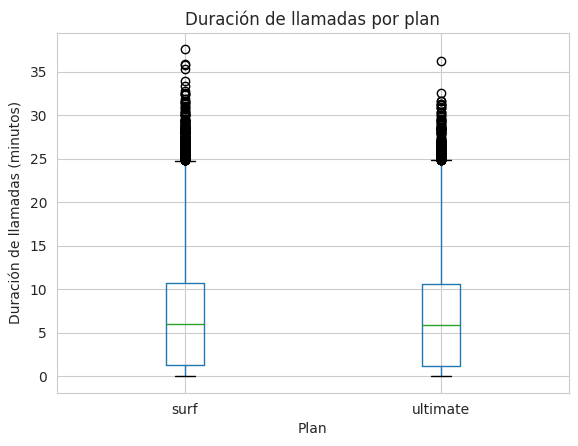

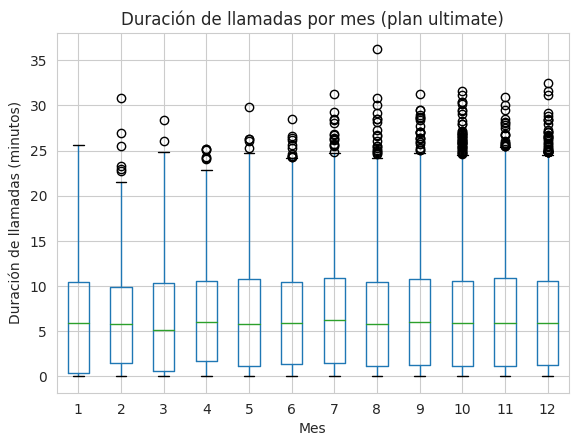

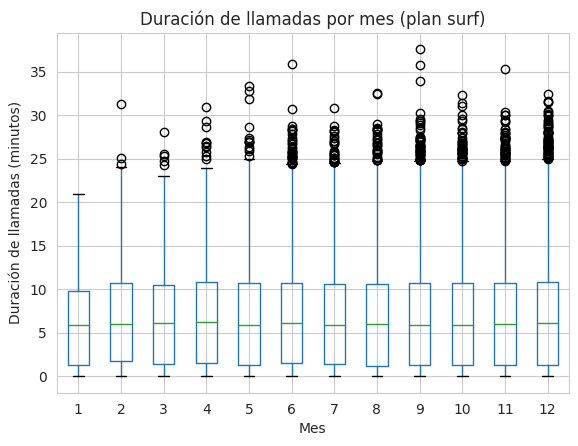

In [ ]:

# Traza un diagrama de caja para visualizar la distribución de la duración mensual de llamadas
#Boxplot de la duración de llamadas por año y sin separar por planes 
#sns.boxplot(calls['duration'])
#calls['duration'].plot(kind='box')
#plt.ylabel('Duración de llamadas (minutos)')
#plt.title('Diagrama de caja de duración de llamadas')
#plt.show()
#Boxplot de la duración de llamadas por plan
calls2[['duration', 'plan_name']].boxplot(by='plan_name')
plt.xlabel('Plan')
plt.ylabel('Duración de llamadas (minutos)')
plt.title('Duración de llamadas por plan')
plt.suptitle('')
plt.show()
#Boxplot de la duración de llamadas por mes y por plan : ULTIMATE
calls2[calls2['plan_name'] == 'ultimate'].boxplot(column='duration', by='month')
plt.xlabel('Mes')
plt.ylabel('Duración de llamadas (minutos)')
plt.title('Duración de llamadas por mes (plan ultimate)')
plt.suptitle('')
plt.show()
#Boxplot de la duración de llamadas por mes y por plan : SURF
calls2[calls2['plan_name'] == 'surf'].boxplot(column='duration', by='month')
plt.xlabel('Mes')
plt.ylabel('Duración de llamadas (minutos)')
plt.title('Duración de llamadas por mes (plan surf)')
plt.suptitle('')
plt.show()



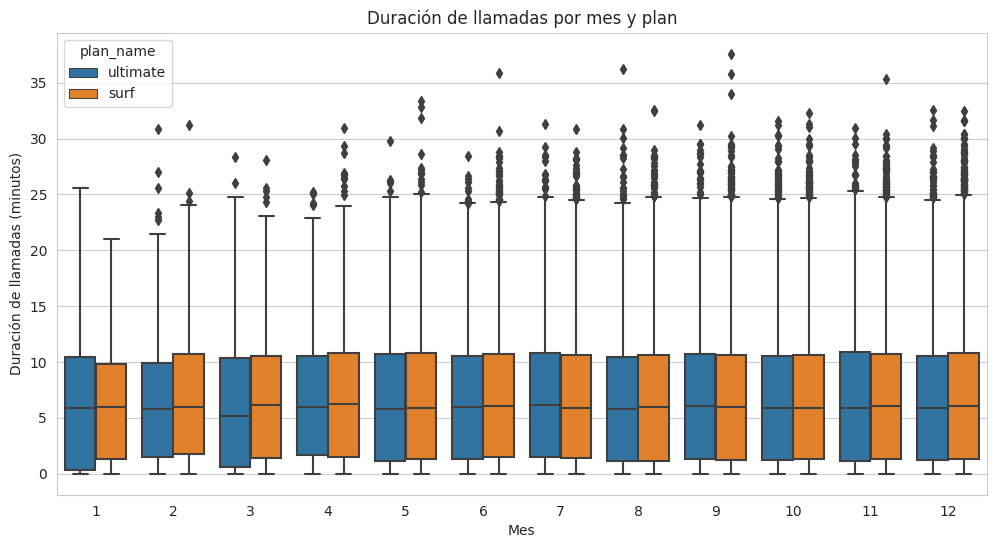

In [ ]:
#encontré una forma de ver ambos en una sola gráfica usando seaborn 
sns.set_style("whitegrid")
plt.figure(figsize=(12,6))  
sns.boxplot(data=calls2, x='month', y='duration', hue='plan_name')
plt.xlabel('Mes')
plt.ylabel('Duración de llamadas (minutos)')
plt.title('Duración de llamadas por mes y plan')
plt.show()



CONCLUSIONES 

Como podemos observar, el promedio de la duración de llamadas entre planes (Surf y Ultimate) es muy similar a lo largo de los meses (alrededor de 6-7 minutos por llamada). La distribución de esta duración también es comparable entre planes y lo que podemos añadir es que existe un número de clientes mayor para el plan de Surf (n= 94084) que para el plan Ultimate (n=43651).
Además de la media, se calcularon otras medidas de dispersión como la varianza y la desviación estándar de la duración de las llamadas por mes y por plan. La tabla con estos datos indican una dispersión  “amplia” y semejante para ambos planes. Lo cual indica que los clientes de ambos planes realizan tanto llamadas cortas como largas a lo largo del año.
Por último, nuestros gráficos de caja muestran que ambos planes presentan valores atípicos en todos los meses (excepto Enero), especialmente hacia finales del año (probablemente debido a las fiestas o vacaciones…)
Por lo tanto, la duración de las llamadas no parece ser el factor que diferencie el comportamiento de los usuarios de cada plan.


### Mensajes

plan_name   surf  ultimate
month                     
1             21        62
2            108       151
3            351       243
4            870       463
5           1849       931
6           2454      1379
7           3271      1937
8           4662      2732
9           5968      3259
10          8020      4181
11          9165      4903
12         12275      6796


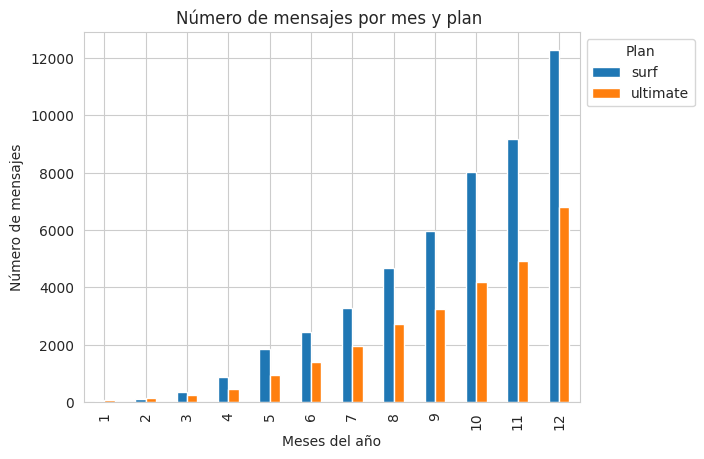

In [ ]:
# Comprara el número de mensajes que tienden a enviar cada mes los usuarios de cada plan
users_plan = users[['user_id','plan_name']]
sms2=sms.merge(users_plan,on='user_id',how='left')
#print(sms2)
#Número de SMS por cada plan y por mes 
sms_count= sms2.groupby(['plan_name','month'])['id'].count().reset_index()
sms_count= sms_count.rename(columns={'id':'count'})
#print(sms_count)
#print((sms2['month']== 1).sum()) 
sms_count_pivot = sms_count.pivot(index= 'month',columns='plan_name',values='count')
print(sms_count_pivot)
ax = sms_count_pivot.plot(kind='bar',legend= True, xlabel ='Meses del año',
                          ylabel ='Número de mensajes',
                          title= 'Número de mensajes por mes y plan ')
ax.legend(title='Plan', bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

plan_name       surf   ultimate
month                          
1          21.000000  20.666667
2          21.600000  25.166667
3          21.937500  34.714286
4          24.166667  28.937500
5          33.017857  44.333333
6          33.616438  36.289474
7          35.945055  41.212766
8          37.596774  47.929825
9          39.523179  45.901408
10         42.433862  46.977528
11         40.553097  47.601942
12         48.326772  53.936508


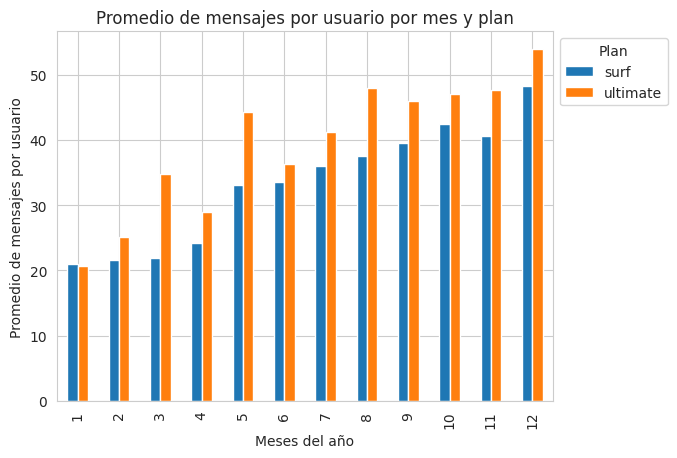

In [ ]:
#Lo anterior solo contó los mensajes . Si quisieramos saber cual es la tendencia de enviar mensajes (un promedio) por usuario
#Considero que es importante porque el simple conteo puede sesgar un poco los resultados y decir que en el plan surf se envian  
#mas SMS pero es solo que en ese plan hay más usuarios como vimos anteriormente.

users_plan = users[['user_id','plan_name']]
sms2 = sms.merge(users_plan, on='user_id', how='left')
# Número de mensajes por usuario, mes y plan
sms_user_month = sms2.groupby(['plan_name','month','user_id'])['id'].count().reset_index()
sms_user_month = sms_user_month.rename(columns={'id':'sms_per_user'})
#print(sms_user_month.head(15))
# Promedio de llamadas por plan y mes
sms_avg=sms_user_month.groupby(['plan_name','month'])['sms_per_user'].mean().reset_index()
sms_avg = sms_avg.rename(columns={'sms_per_user':'sms_per_user_mean'})

sms_avg_pivot = sms_avg.pivot(index='month', columns='plan_name', values='sms_per_user_mean')
print(sms_avg_pivot)
ax = sms_avg_pivot.plot(kind='bar', legend=True, xlabel='Meses del año',
                        ylabel='Promedio de mensajes por usuario', title='Promedio de mensajes por usuario por mes y plan')
ax.legend(title='Plan', bbox_to_anchor=(1, 1), loc='upper left')
plt.show()



     plan_name  month  user_id  sms_per_user
0         surf      1     1362            21
1         surf      2     1099             3
2         surf      2     1138             7
3         surf      2     1261            11
4         surf      2     1362            58
...        ...    ...      ...           ...
1801  ultimate     12     1477             2
1802  ultimate     12     1478            14
1803  ultimate     12     1482             5
1804  ultimate     12     1487            66
1805  ultimate     12     1497            50

[1806 rows x 4 columns]


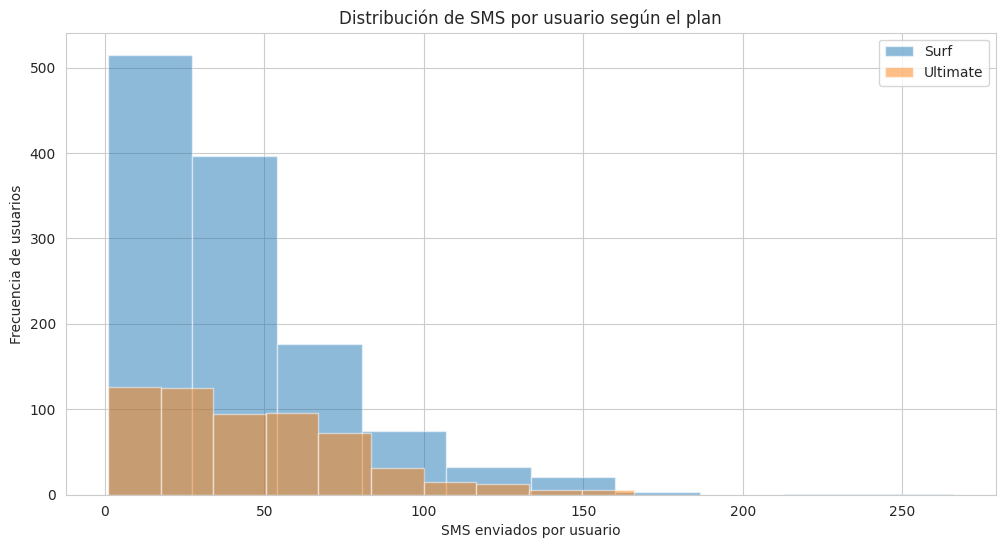

Promedio_SMS_surf: 40.10965630114566 Número de datos: 1222
Promedio_SMS_ultimate: 46.29623287671233 Número de datos: 584


In [ ]:
#DISTRIBUCION de sms por plan en los meses (no distingue un mes en particular) 
# Número de mensajes por usuario, mes y plan
sms_user_month = sms2.groupby(['plan_name','month','user_id'])['id'].count().reset_index()
sms_user_month = sms_user_month.rename(columns={'id':'sms_per_user'})
print(sms_user_month)
#filtar por plan 
sms_surf = sms_user_month[sms_user_month['plan_name'] == 'surf']['sms_per_user']
sms_ultimate = sms_user_month[sms_user_month['plan_name'] == 'ultimate']['sms_per_user']
plt.figure(figsize=(12,6))
# Surf
plt.hist(sms_surf,alpha=0.5,bins=10,label='Surf')
# Ultimate
plt.hist(sms_ultimate,alpha=0.5, bins=10,label='Ultimate')
plt.xlabel('SMS enviados por usuario')
plt.ylabel('Frecuencia de usuarios')
plt.title('Distribución de SMS por usuario según el plan')
plt.legend()
plt.show()

print('Promedio_SMS_surf:', sms_surf.mean(),'Número de datos:', len(sms_surf))
print('Promedio_SMS_ultimate:',sms_ultimate.mean(),'Número de datos:',len(sms_ultimate))


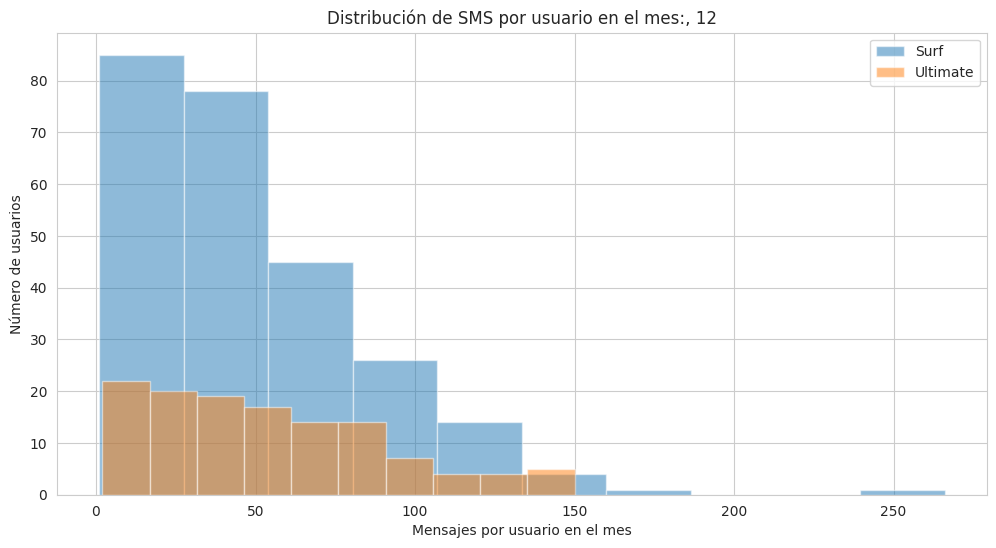

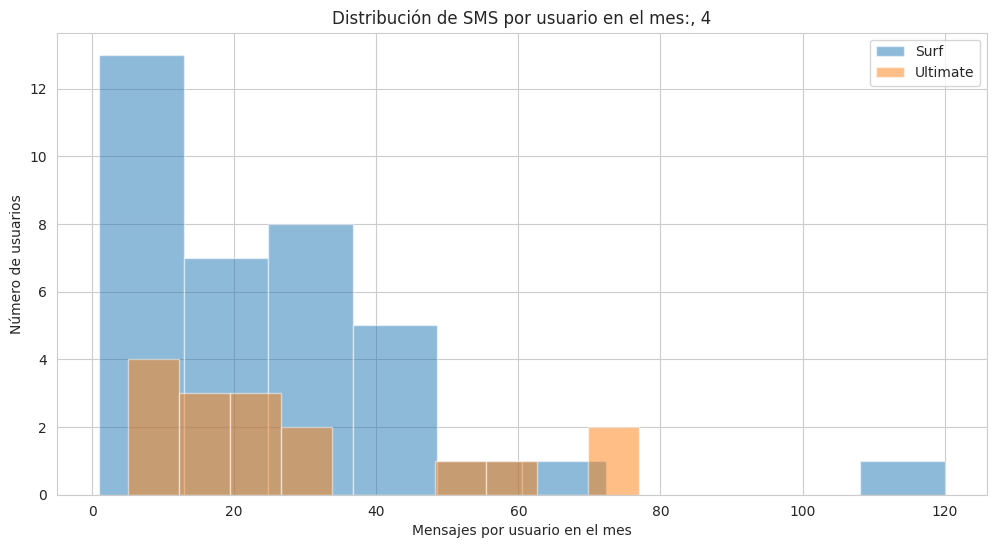

In [ ]:
#Distribuciones por mes

month_to_plot = 12  # por ejemplo, diciembre
data_surf = sms_user_month[(sms_user_month['plan_name'] == 'surf') &
                           (sms_user_month['month'] == month_to_plot)]
data_ultimate = sms_user_month[(sms_user_month['plan_name'] == 'ultimate') &
                               (sms_user_month['month'] == month_to_plot)]

plt.figure(figsize=(12,6))
plt.hist(data_surf['sms_per_user'], alpha=0.5, bins=10, label='Surf')
plt.hist(data_ultimate['sms_per_user'], alpha=0.5, bins=10, label='Ultimate')
plt.xlabel('Mensajes por usuario en el mes')
plt.ylabel('Número de usuarios')
plt.title(f'Distribución de SMS por usuario en el mes:, {month_to_plot}')
plt.legend()
plt.show()


month_to_plot = 4  # por ejemplo, enero

data_surf = sms_user_month[(sms_user_month['plan_name'] == 'surf') &
                           (sms_user_month['month'] == month_to_plot)]

data_ultimate = sms_user_month[(sms_user_month['plan_name'] == 'ultimate') &
                               (sms_user_month['month'] == month_to_plot)]


plt.figure(figsize=(12,6))
plt.hist(data_surf['sms_per_user'], alpha=0.5, bins=10, label='Surf')
plt.hist(data_ultimate['sms_per_user'], alpha=0.5, bins=10, label='Ultimate')
plt.xlabel('Mensajes por usuario en el mes')
plt.ylabel('Número de usuarios')
plt.title(f'Distribución de SMS por usuario en el mes:, {month_to_plot}')
plt.legend()
plt.show()


In [ ]:
# Calcula la media y la varianza de los sms(por plan /tarifa)
#print(sms_user_month.head(25))
mean_var_std_sms = sms_user_month.groupby(['plan_name','month'])['sms_per_user'].agg(sms_mean='mean',varianza = 'var', std='std').reset_index()
print(mean_var_std_sms)

   plan_name  month   sms_mean     varianza        std
0       surf      1  21.000000          NaN        NaN
1       surf      2  21.600000   512.800000  22.645088
2       surf      3  21.937500   352.062500  18.763329
3       surf      4  24.166667   534.028571  23.109058
4       surf      5  33.017857   867.945130  29.460909
5       surf      6  33.616438   936.406393  30.600758
6       surf      7  35.945055   907.985836  30.132803
7       surf      8  37.596774  1013.315762  31.832621
8       surf      9  39.523179   943.051126  30.709137
9       surf     10  42.433862  1234.491613  35.135333
10      surf     11  40.553097  1002.523835  31.662657
11      surf     12  48.326772  1355.129952  36.812090
12  ultimate      1  20.666667   310.333333  17.616280
13  ultimate      2  25.166667   465.366667  21.572359
14  ultimate      3  34.714286   613.904762  24.777102
15  ultimate      4  28.937500   512.862500  22.646468
16  ultimate      5  44.333333  1246.933333  35.311943
17  ultima

     plan_name  month  user_id  sms_per_user
0         surf      1     1362            21
1         surf      2     1099             3
2         surf      2     1138             7
3         surf      2     1261            11
4         surf      2     1362            58
...        ...    ...      ...           ...
1801  ultimate     12     1477             2
1802  ultimate     12     1478            14
1803  ultimate     12     1482             5
1804  ultimate     12     1487            66
1805  ultimate     12     1497            50

[1806 rows x 4 columns]


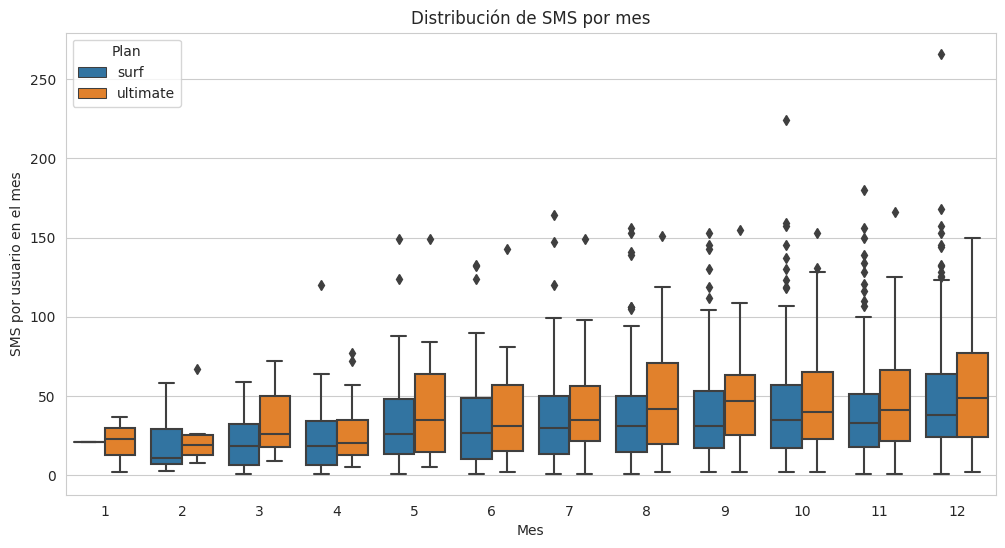

In [ ]:

# Diagrama de caja para visualizar la distribución de los mensajes
print(sms_user_month)
sns.set_style("whitegrid")  # o "whitegrid" si prefieres
plt.figure(figsize=(12,6))
sns.boxplot(data=sms_user_month, x='month', y='sms_per_user', hue='plan_name')
plt.xlabel('Mes')
plt.ylabel('SMS por usuario en el mes')
plt.title('Distribución de SMS por mes')
plt.legend(title='Plan')
plt.show()


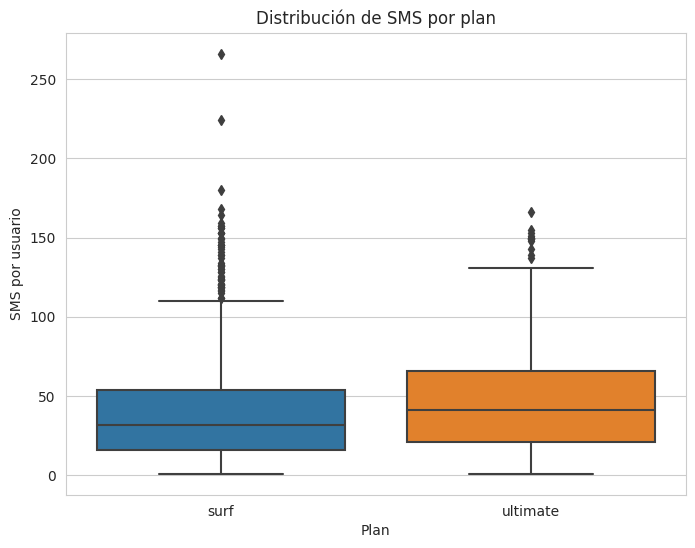

In [ ]:


#boxplot por planes con meses todos juntos 
plt.figure(figsize=(8,6))
sns.boxplot(data=sms_user_month, x='plan_name', y='sms_per_user')
plt.xlabel('Plan')
plt.ylabel('SMS por usuario')
plt.title('Distribución de SMS por plan')
plt.show()



CONCLUSIONES

En primer lugar, es importante recordar que hay más usuarios en el plan Surf que en Ultimate, por lo que el conteo total de mensajes por mes favorece a Surf. Por este motivo comparamos los planes usando el promedio de SMS por usuario.
Al analizar el número de mensajes enviados por usuario y por mes, observamos que la tendencia general es similar en ambos planes, pero con valores más altos para Ultimate. En el plan Surf, los usuarios envían en promedio alrededor de 40 SMS al mes (Promedio_SMS_surf ≈ 40.1, N = 1222), mientras que en el plan Ultimate el promedio es de aproximadamente 46 SMS al mes (Promedio_SMS_ultimate ≈ 46.3, N = 584). Además, en ambos planes el número de mensajes por usuario aumenta a lo largo del año, especialmente en la segunda mitad.
Las distribuciones de SMS por usuario presentan un sesgo a la derecha en los dos planes: la mayoría de los clientes envía pocos mensajes y solo una minoría envía muchísimos. Esto se refleja en las varianzas y desviaciones estándar altas, que indican una gran dispersión en el uso de SMS. Los boxplots muestran numerosos valores atípicos en ambos planes, sobre todo hacia el final del año. Aunque en Surf se observan muchos outliers con números muy elevados de SMS, la mediana y la caja de Ultimate se sitúan en niveles más altos, lo que confirma que el uso típico de mensajes es mayor en este plan.
En resumen, el comportamiento respecto al envío de SMS sí varía en función del plan: aunque ambos muestran un aumento progresivo en el número de mensajes a lo largo del año y una alta variabilidad entre usuarios, los clientes de Ultimate tienden a enviar más SMS por mes que los clientes de Surf.


### Internet

plan_name      surf  ultimate
month                        
1          0.317374  0.409451
2          0.347534  0.395579
3          0.365996  0.415291
4          0.352298  0.368584
5          0.350719  0.362162
6          0.349015  0.369741
7          0.360520  0.360958
8          0.362197  0.365228
9          0.355899  0.366376
10         0.356906  0.367057
11         0.351767  0.363360
12         0.354261  0.355661


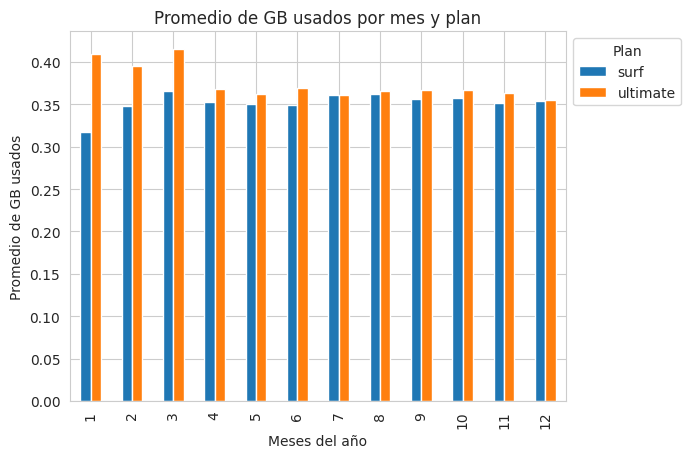

In [ ]:
#Comparar los gb usados promedio  por cada plan y por cada mes. Traza un gráfico de barras para visualizarla.
users_plan = users[['user_id', 'plan_name']]
internet2 = internet.merge(users_plan,on='user_id', how='left')
#print(internet2.head(15))
internet_user_month = (internet2.groupby(['plan_name', 'month'])['gb_used'].mean().reset_index().rename(columns={'gb_used': 'gb_mean'}))
#print(internet_user_month)
gb_avg_pivot = internet_user_month.pivot(index='month', columns='plan_name', values='gb_mean')
print(gb_avg_pivot)
ax = gb_avg_pivot.plot(kind='bar', legend=True, xlabel='Meses del año',
                        ylabel='Promedio de GB usados', title='Promedio de GB usados por mes y plan')
ax.legend(title='Plan', bbox_to_anchor=(1, 1), loc='upper left')
plt.show()


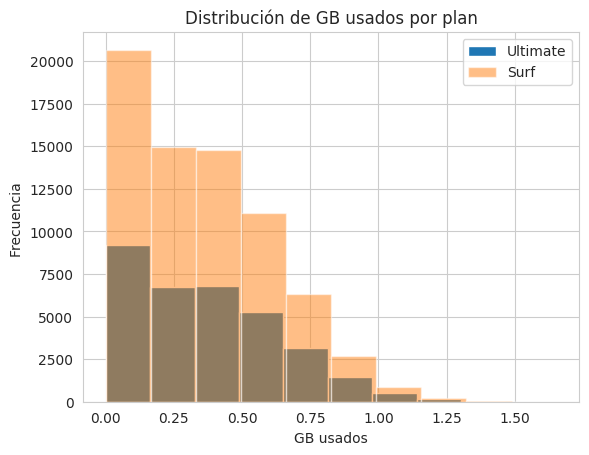

Promedio_GB_surf: 0.35531699756782925 Número de datos: 71586
Promedio_GB_ultimate: 0.36415312502350405 Número de datos: 33239


In [ ]:
# Compara el número de gb mensuales que necesitan los usuarios de cada plan. Traza un histograma.
#SIN DISTINGUIR MESES O PLAN 
#internet2['gb_used'].plot(kind='hist', bins= 10)
#plt.xlabel('GB usados')
#plt.ylabel('Frecuencia(# de Clientes)')
#plt.title('Distribución de GB usados')
#plt.show()

#filtrar GB por plan 
GB_ultimate = internet2[internet2['plan_name'] == 'ultimate']['gb_used']
GB_surf = internet2[internet2['plan_name'] == 'surf']['gb_used']

#Distribucion de los GB por plan /tarifa
plt.hist(GB_ultimate, bins=10, alpha=1, label='Ultimate')
plt.hist(GB_surf, bins=10, alpha=0.5, label='Surf')

plt.xlabel('GB usados')
plt.ylabel('Frecuencia ')
plt.title('Distribución de GB usados por plan')
plt.legend()
plt.show()

print('Promedio_GB_surf:', GB_surf.mean(),'Número de datos:', len(GB_surf))
print('Promedio_GB_ultimate:',GB_ultimate.mean(),'Número de datos:',len(GB_ultimate))



In [ ]:
# Calcula la media y la varianza de los GB usados. (por plan /tarifa)
#print(internet.describe()) #media, std en todo el año de ambos planes
mean_var_std = internet2.groupby(['plan_name','month'])['gb_used'].agg(GB_mean='mean',varianza = 'var', std='std').reset_index()
print(mean_var_std)

   plan_name  month   GB_mean  varianza       std
0       surf      1  0.317374  0.088838  0.298057
1       surf      2  0.347534  0.066264  0.257417
2       surf      3  0.365996  0.077581  0.278533
3       surf      4  0.352298  0.072899  0.269999
4       surf      5  0.350719  0.072169  0.268642
5       surf      6  0.349015  0.072554  0.269359
6       surf      7  0.360520  0.073479  0.271070
7       surf      8  0.362197  0.072749  0.269721
8       surf      9  0.355899  0.072851  0.269909
9       surf     10  0.356906  0.071564  0.267515
10      surf     11  0.351767  0.072166  0.268637
11      surf     12  0.354261  0.073330  0.270795
12  ultimate      1  0.409451  0.081636  0.285721
13  ultimate      2  0.395579  0.074422  0.272803
14  ultimate      3  0.415291  0.085130  0.291770
15  ultimate      4  0.368584  0.074986  0.273836
16  ultimate      5  0.362162  0.075805  0.275327
17  ultimate      6  0.369741  0.077526  0.278435
18  ultimate      7  0.360958  0.072482  0.269226


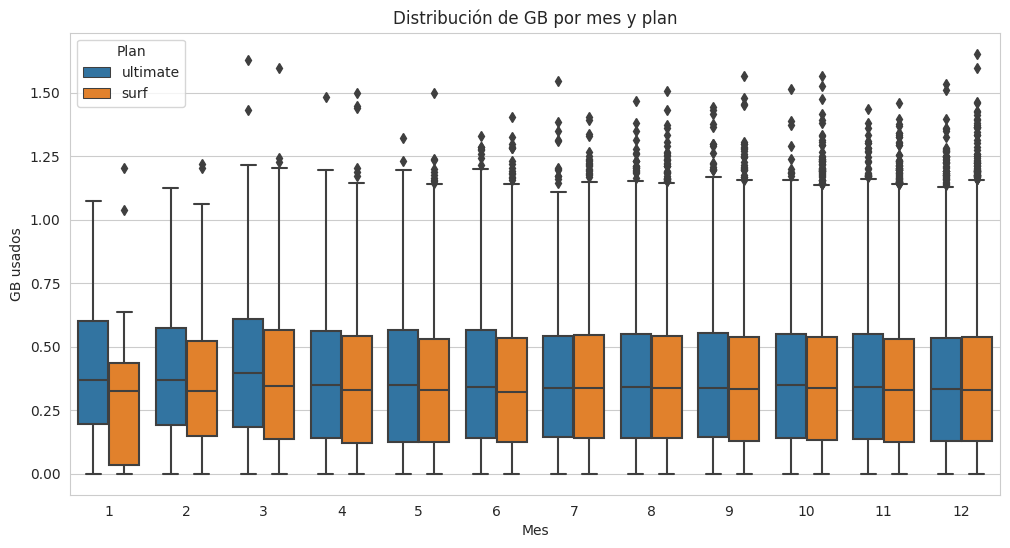

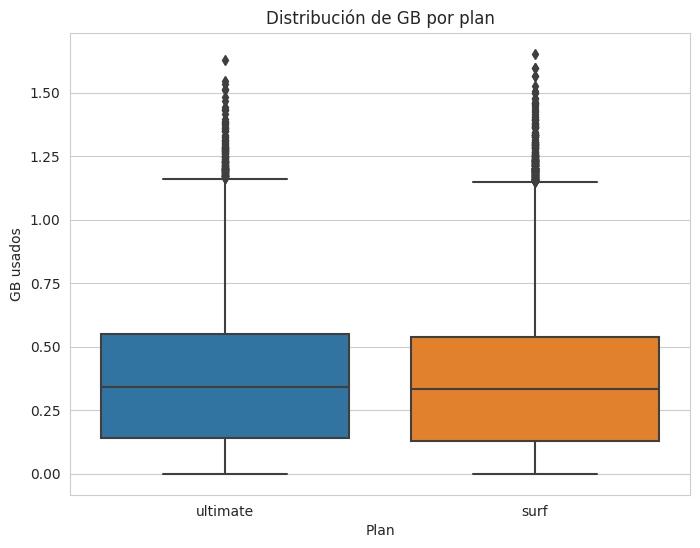

In [ ]:
# Diagrama de caja para visualizar la distribución de los GB
sns.set_style("whitegrid")  # o "whitegrid" si prefieres
plt.figure(figsize=(12,6))
sns.boxplot(data=internet2, x='month', y='gb_used', hue='plan_name')
plt.xlabel('Mes')
plt.ylabel('GB usados')
plt.title('Distribución de GB por mes y plan')
plt.legend(title='Plan')
plt.show()
#boxplot por planes con meses todos juntos 
plt.figure(figsize=(8,6))
sns.boxplot(data=internet2, x='plan_name', y='gb_used')
plt.xlabel('Plan')
plt.ylabel('GB usados')
plt.title('Distribución de GB por plan')
plt.show()

CONCLUSIONES 
Al analizar el consumo de datos para ambos planes, observamos que el uso de internet por mes es muy similar con valores de GB promedio que oscilan  entre ~0.31 y ~0.42 GB (unos 310–420 MB). En casi todos los meses, el promedio de GB del plan ultimate es ligeramente mayor que el plan surf .La diferencia no es grande (aunque se tendría que ver si es significativa, principalmente  en los primeros 3 meses que es un poco más notable la diferencia), pero si consistente para todos los meses. 
Las distribuciones de GB usados por plan presentan un claro sesgo a la derecha: muchos usuarios con poco consumo y pocos con consumos más altos. Ambas distribuciones son muy parecidas y su promedio es similar ~0.355 GB (Surf) vs ~0.364 GB (Ultimate). Aquí también el número de datos es mayor para Surf(n = 71586 que para Ultimate (n = 33239)

Además de la media, calculamos la varianza y la desviación estándar. Las cuales como se puede observar, son muy parecidas entre planes (alrededor de 0.07–0.09 de varianza y ~0.26–0.29 de std). Esto nos indica que la dispersión o variabilidad en el consumo de datos es similar en Surf y Ultimate (ambos tienen usuarios que consumen poco y usuarios que consumen mucho).
En los boxplots de GB usados por mes, se aprecia que las distribuciones de consumo de datos en Surf y Ultimate son muy parecidas en todos los meses (Excepto en los primeros 3 meses del año donde las diferencias son un poco más notables. Véase Enero, mes donde surf  tiene más valores pequeños y unos cuantos muy grandes). A partir del mes 4 (Abril) los patrones de uso de internet entre ambos planes es casi igual con medianas muy parecidas también.  En cuanto al número de valores atípicos podemos observar que incrementa para ambos planes hacia la segunda mitad del año, lo cual coincide con lo que hemos estado observando para SMS o duración de llamadas. 

En resumen, el comportamiento de los usuarios en términos de uso de datos no difiere y/o no varía mucho entre planes: el consumo típico de GB es muy similar entre Surf y Ultimate. Con una ligera tendencia a un mayor uso en el plan Ultimate en los primeros meses del año


## Ingreso

plan_name       surf   ultimate
month                          
1          20.000000  70.000000
2          23.914000  70.000000
3          38.540625  78.000000
4          40.591429  73.062500
5          50.857170  71.000000
6          52.081000  72.081081
7          61.806404  72.382979
8          64.383109  72.456140
9          57.196871  71.380282
10         65.368343  72.147727
11         57.116606  72.127451
12         68.777561  72.744000


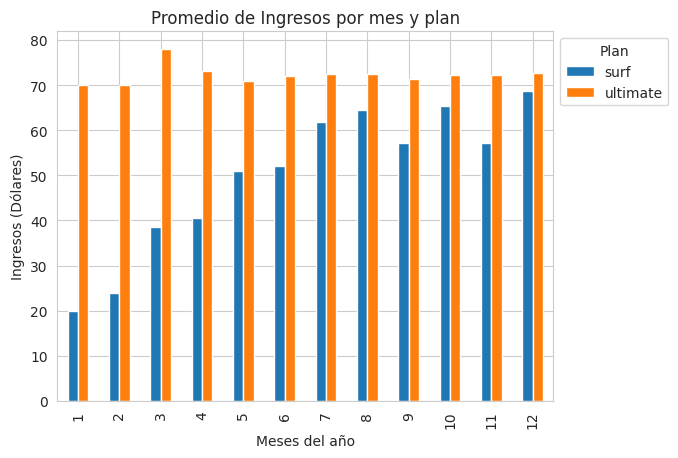

In [ ]:
#print(data_plan_users_month.info())
#print(data_plan_users_month.head(10))
#Comparar ingreso promedio  por cada plan y por cada mes. Traza un gráfico de barras para visualizarla.

revenue_mean = (data_plan_users_month.groupby(['plan_name', 'month'])['total_payment_per_user'].mean().reset_index().rename(columns={'total_payment_per_user':'total_payment_mean'}))
#print(revenue_mean)
revenue_avg_pivot = revenue_mean.pivot(index='month', columns='plan_name', values='total_payment_mean')
print(revenue_avg_pivot)
ax = revenue_avg_pivot.plot(kind='bar', legend=True, xlabel='Meses del año',
                        ylabel='Ingresos (Dólares)', title='Promedio de Ingresos por mes y plan')
ax.legend(title='Plan', bbox_to_anchor=(1, 1), loc='upper left')
plt.show()


plan_name      surf  ultimate
month                        
1             20.00     210.0
2            119.57     350.0
3            616.65     546.0
4           1420.70    1169.0
5           2695.43    1491.0
6           3645.67    2667.0
7           5500.77    3402.0
8           7661.59    4130.0
9           8407.94    5068.0
10         11831.67    6349.0
11         12451.42    7357.0
12         16919.28    9093.0


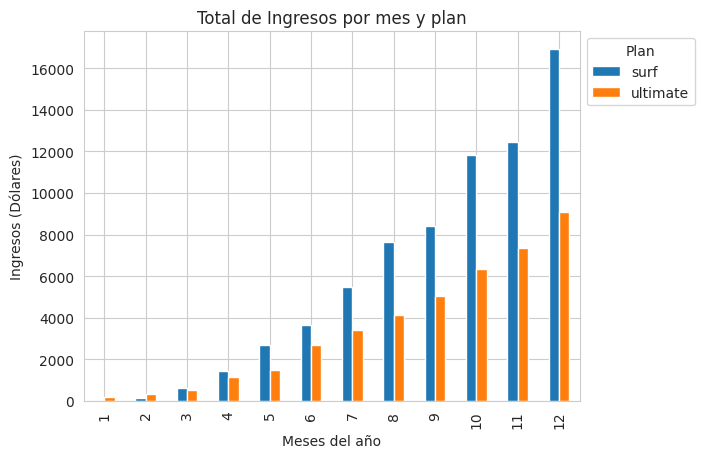

In [ ]:
revenue_total = (data_plan_users_month.groupby(['plan_name', 'month'])['total_payment_per_user'].sum().reset_index().rename(columns={'total_payment_per_user':'total_payment_sum'}))
#print(revenue_total)
revenue_total_pivot = revenue_total.pivot(index='month', columns='plan_name', values='total_payment_sum')
print(revenue_total_pivot)
ax = revenue_total_pivot.plot(kind='bar', legend=True, xlabel='Meses del año',
                        ylabel='Ingresos (Dólares)', title='Total de Ingresos por mes y plan')
ax.legend(title='Plan', bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

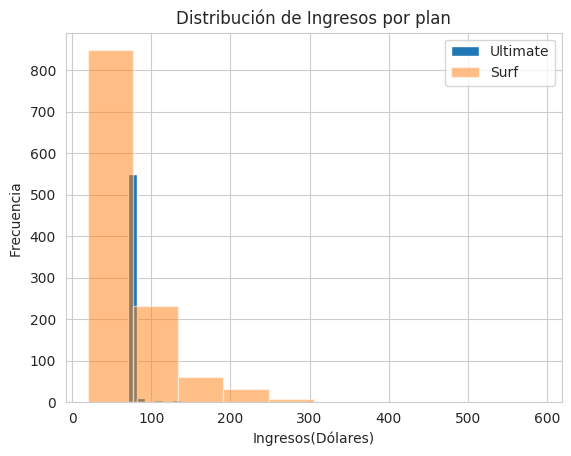

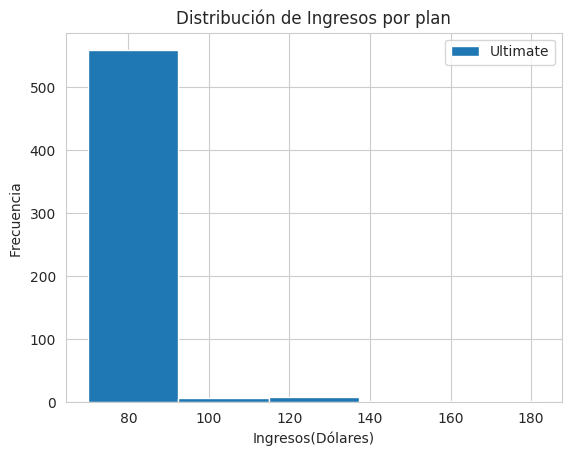

Promedio_revenue_surf: 60.41583898305085 Número de datos: 1180
Promedio_revenue_ultimate: 72.24870466321244 Número de datos: 579


In [ ]:
# Compara el ingreso mensuales de cada plan. Traza un histograma.
#print(data_plan_users_month)
#filtrar INGRESOS por plan 
revenue_ultimate = data_plan_users_month[data_plan_users_month['plan_name'] == 'ultimate']['total_payment_per_user']
revenue_surf = data_plan_users_month[data_plan_users_month['plan_name'] == 'surf']['total_payment_per_user']

#Distribucion de ingresos por plan /tarifa

plt.hist(revenue_ultimate, bins=10, alpha=1, label='Ultimate')
plt.hist(revenue_surf, bins=10, alpha=0.5, label='Surf')
plt.xlabel('Ingresos(Dólares)')
plt.ylabel('Frecuencia ')
plt.title('Distribución de Ingresos por plan')
plt.legend()
plt.show()


plt.hist(revenue_ultimate, bins=5, alpha=1, label='Ultimate')
plt.xlabel('Ingresos(Dólares)')
plt.ylabel('Frecuencia ')
plt.title('Distribución de Ingresos por plan')
plt.legend()
plt.show()
print('Promedio_revenue_surf:', revenue_surf.mean(),'Número de datos:', len(revenue_surf))
print('Promedio_revenue_ultimate:',revenue_ultimate.mean(),'Número de datos:',len(revenue_ultimate))



In [ ]:
# Calcula la media y la varianza de los ingresos. (por plan /tarifa)
mean_var_std = data_plan_users_month.groupby(['plan_name','month'])['total_payment_per_user'].agg(revenue_mean='mean',varianza = 'var', std='std').reset_index()
print(mean_var_std)

   plan_name  month  revenue_mean     varianza        std
0       surf      1     20.000000          NaN        NaN
1       surf      2     23.914000    28.746980   5.361621
2       surf      3     38.540625   549.488006  23.441161
3       surf      4     40.591429  1250.948289  35.368747
4       surf      5     50.857170  2308.394898  48.045758
5       surf      6     52.081000  2425.189308  49.246211
6       surf      7     61.806404  3267.670721  57.163544
7       surf      8     64.383109  3335.250428  57.751627
8       surf      9     57.196871  2031.352659  45.070530
9       surf     10     65.368343  3055.703326  55.278416
10      surf     11     57.116606  2206.434557  46.972700
11      surf     12     68.777561  3979.221484  63.081071
12  ultimate      1     70.000000     0.000000   0.000000
13  ultimate      2     70.000000     0.000000   0.000000
14  ultimate      3     78.000000   235.666667  15.351439
15  ultimate      4     73.062500   150.062500  12.250000
16  ultimate  

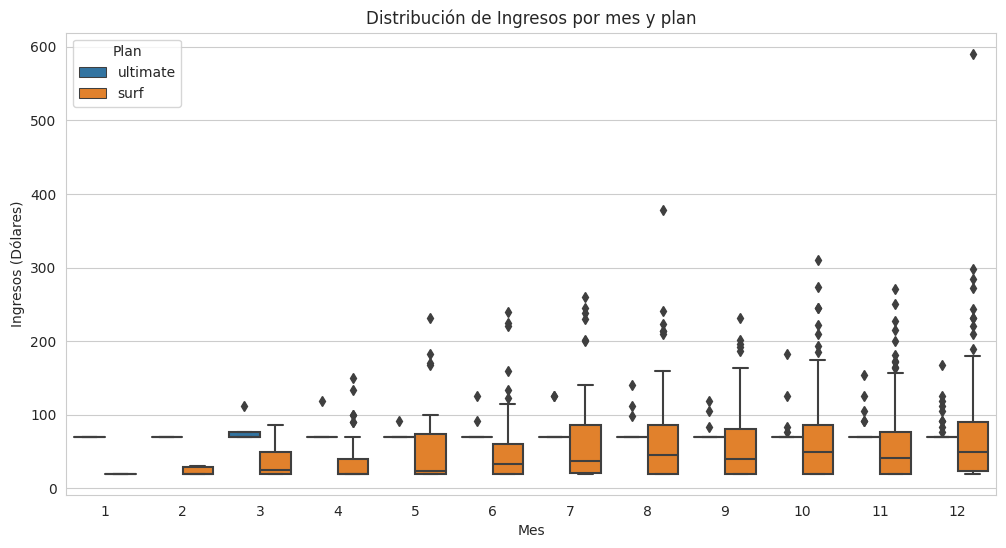

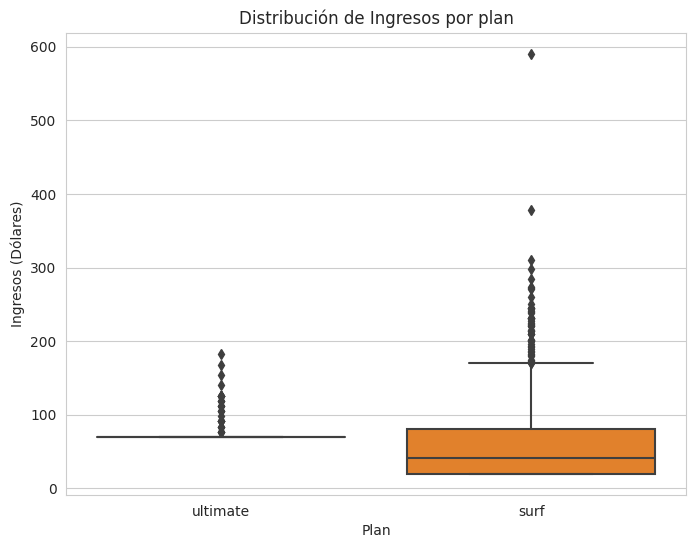

In [ ]:
# Diagrama de caja para visualizar la distribución de los INGRESOS
sns.set_style("whitegrid")  # o "whitegrid" 
plt.figure(figsize=(12,6))
sns.boxplot(data=data_plan_users_month, x='month', y='total_payment_per_user', hue='plan_name')
plt.xlabel('Mes')
plt.ylabel('Ingresos (Dólares)')
plt.title('Distribución de Ingresos por mes y plan')
plt.legend(title='Plan')
plt.show()
#boxplot por planes con meses todos juntos 
plt.figure(figsize=(8,6))
sns.boxplot(data=data_plan_users_month, x='plan_name', y='total_payment_per_user')
plt.xlabel('Plan')
plt.ylabel('Ingresos (Dólares)')
plt.title('Distribución de Ingresos por plan')
plt.show()

CONCLUSIONES 

En los análisis respecto a las ganancias o ingresos que se obtienen por mes y plan, observamos que el total de ganancias obtenidas por el plan Surf es aparentemente mayor que las ganancias que generan el plan Ultimate. Para verificarlo, calculamos el ingreso promedio.  En el plan Ultimate el ingreso medio está siempre alrededor de 70–78 USD al mes. Es decir, es bastante estable y cercano a la cuota fija del plan (casi todos pagan lo mismo, con pocos pagos extras). En el plan Surf, el ingreso medio empieza en 20 USD en enero y va incrementando hasta alrededor de los 60–69 USD en los últimos meses. Eso indica que muchos usuarios de Surf generan más cargos por excedentes (minutos/SMS/datos extra), lo que hace que el ingreso medio de Surf se acerque al de Ultimate en los últimos meses.
Al analizar la distribución de los ingresos por plan,  podemos confirmar lo anterior. Por ejemplo, observamos que la distribución de Surf es más dispersa lo cual indica que tiene algunos clientes que generan cargos adicionales por excedentes, lo que alarga la distribución hacia valores más altos de ingreso (sesgo a la derecha).

Además del promedio, también calculamos varianza y desviación estándar de los ingresos mensuales por plan. Estos datos vuelven a confirmar lo que hemos descrito,  mostrando una variabilidad muy alta para Surf y no para el plan Ultimate. 
En cuanto a los boxplots, volvemos a observar que los ingresos para el plan Ultimate son bastante estables y concentrados alrededor de la cuota fija, mientras que en Surf los ingresos aumentan y se vuelven mucho más dispersos a lo largo del año. Hacia los últimos meses aparecen muchos valores atípicos en Surf, los cuales corresponden a cargos muy elevados por exceder los límites de su plan. Podemos agregar que el boxplot global de ingresos muestra que el plan Ultimate tiene una mediana más alta y una distribución más concentrada, mientras que el plan Surf presenta ingresos más bajos en promedio pero con una dispersión mucho mayor. Esto indica que Surf depende más de un grupo de usuarios que genera muchos cargos extra, mientras que Ultimate ofrece ingresos más altos y estables por usuario.

En resumen, los ingresos sí varían en función del plan ya que Ultimate aporta más ingresos promedio y de forma muy estable. Mientras que Surf produce ingresos más bajos en promedio, pero con una gran variabilidad y algunos usuarios muy rentables debido a los excedentes.Desde mi opinión e interpretación de los datos, Ultimate parece ser un plan más rentable por usuario, mientras que Surf depende más de los patrones de sobreuso de una parte de sus clientes.

## Prueba las hipótesis estadísticas

Formulación de hipótesis 1
Prueba de hipótesis bilateral o de 2 colas. 

Ho: No existen diferencias entre los ingresos promedio procedentes de los usuarios de los planes Ultimate y Surf.  O...
Ho: El ingreso promedio de los usuarios del plan Surf es igual al ingreso promedio de los usuarios del plan Ultimate.

H1(Ha): Existen diferencias entre los ingresos promedio procedentes de los usuarios de los planes Ultimate y Surf   O...
H1(Ha): El ingreso promedio de los usuarios del plan Surf es diferente al ingreso promedio de los usuarios del plan Ultimate.

Se eligió una prueba de hipótesis de 2 colas porque solo queremos saber si existen diferencias, no si alguno es > o < que el otro.
Usaremos un nivel de significancia de alpha (a) = 0.05 porque es el estándar, no es exigente pero tampoco tan laxo. 
Si el p-value < 0.05. Rechazaremos la Ho a favor de la H1(Ha)

Usaremos una prueba t para muestras independientes (t-test de dos muestras) porque compararemos las medias de ingresos generados entre dos planes 

In [ ]:
# Prueba las hipótesis
revenue_mean = (data_plan_users_month.groupby(['plan_name', 'month'])['total_payment_per_user'].mean().reset_index().rename(columns={'total_payment_per_user':'total_payment_mean'}))
revenue_avg_pivot = revenue_mean.pivot(index='month', columns='plan_name', values='total_payment_mean')
#print(revenue_avg_pivot)
alpha = 0.05
result = st.ttest_ind(revenue_avg_pivot['surf'],revenue_avg_pivot['ultimate'],equal_var = False)
print('valor p =',result.pvalue)
if(result.pvalue < alpha):
    print('Rechazamos la Ho : El ingreso promedio de los usuarios del plan Surf es diferente al ingreso promedio de los usuarios del plan Ultimate')
else:
    print('No se rechaza la Ho:  El ingreso promedio de los usuarios del plan Surf es igual al ingreso promedio de los usuarios del plan Ultimate')

valor p = 0.0005476858128530602
Rechazamos la Ho : El ingreso promedio de los usuarios del plan Surf es diferente al ingreso promedio de los usuarios del plan Ultimate


El resultado de la prueba de hipótesis es coherente con los análisis descriptivos previos, donde observamos que los usuarios de Ultimate generan, en promedio, ingresos mensuales más altos y más estables, mientras que los de Surf presentan ingresos más bajos en promedio, pero con una gran variabilidad y algunos usuarios que pagan mucho más debido a los excedentes.

In [ ]:
# Prueba las hipótesis (agrupado por usuarios y sacando promedio por usuarios)
revenue_mean = (data_plan_users_month.groupby(['plan_name', 'user_id'])['total_payment_per_user'].mean().reset_index().rename(columns={'total_payment_per_user':'total_payment_mean'}))
revenue_avg_pivot = revenue_mean.pivot(index='user_id', columns='plan_name', values='total_payment_mean')

surf = revenue_avg_pivot['surf'].dropna()
ultimate = revenue_avg_pivot['ultimate'].dropna()

alpha = 0.05
result = st.ttest_ind(surf, ultimate, equal_var=False)
print('valor p =',result.pvalue)
if(result.pvalue < alpha):
    print('Rechazamos la Ho : El ingreso promedio de los usuarios del plan Surf es diferente al ingreso promedio de los usuarios del plan Ultimate')
else:
    print('No se rechaza la Ho:  El ingreso promedio de los usuarios del plan Surf es igual al ingreso promedio de los usuarios del plan Ultimate')


valor p = 1.5136174600695587e-07
Rechazamos la Ho : El ingreso promedio de los usuarios del plan Surf es diferente al ingreso promedio de los usuarios del plan Ultimate


Formulación de hipótesis 2
Prueba de hipótesis bilateral o de 2 colas.

Ho: No existen diferencias entre los ingresos promedio procedentes de los usuarios del área Nueva York-Nueva Jersey (NY-NJ) al de otras regiones. O ...

Ho: El ingreso promedio de los usuarios de los usuarios del área NY-NJ es igual al de los usuarios de otras regiones.   

H1(Ha): Existen diferencias entre los ingresos promedio procedentes de los usuarios del área NY-NJ al de los usuarios de otras regiones. O ...
H1(Ha): El ingreso promedio de los usuarios el área NY-NJ es diferente al de los usuarios de otras regiones.

Se eligió una prueba de hipótesis de 2 colas porque solo queremos saber si existen diferencias, no si alguno es > o < que el otro. Usaremos un nivel de significancia de alpha (a) = 0.05 porque es el estándar, no es exigente pero tampoco tan laxo. Si el p-value < 0.05. Rechazaremos la Ho a favor de la H1(Ha)

Usaremos una prueba t para muestras independientes (t-test de dos muestras) porque compararemos las medias de ingresos generados entre los usuarios procedentes de areas distintas 

In [ ]:
# Prueba las hipótesis
revenue_mean = (data_plan_users_month.groupby(['plan_name', 'user_id'])['total_payment_per_user'].mean().reset_index().rename(columns={'total_payment_per_user':'total_payment_mean'}))
users_city = users[['user_id','city']]
#users_city['city'].unique()
revenue_city = revenue_mean.merge(users_city, on='user_id', how= 'left')
#print(revenue_city.head(30))
NY_NJ = revenue_city[revenue_city['city']=='New York-Newark-Jersey City, NY-NJ-PA MSA']['total_payment_mean']
#print(NY_NJ)
other_areas= revenue_city[revenue_city['city']!='New York-Newark-Jersey City, NY-NJ-PA MSA']['total_payment_mean']
#print(other_areas)

In [ ]:
alpha = 0.05
result = st.ttest_ind(NY_NJ, other_areas, equal_var=False)
print('valor p =',result.pvalue)
if(result.pvalue < alpha):
    print('Rechazamos la Ho : El ingreso promedio de los usuarios el área NY-NJ es diferente al de los usuarios de otras regiones')
else:
    print('No se rechaza la Ho:  El ingreso promedio de los usuarios del área NY-NJ no es diferente de los usuarios de otras regiones')


valor p = 0.2039893828130131
No se rechaza la Ho:  El ingreso promedio de los usuarios del área NY-NJ no es diferente de los usuarios de otras regiones


El resultado de la prueba de hipótesis quiere decir que no se encontró evidencia estadísticamente significativa de que el ingreso promedio de los usuarios del área NY–NJ sea diferente al de los usuarios de otras regiones. Lo cual no significa que los ingresos sean exactamente iguales, sino que, con los datos que tenemos, las diferencias observadas podrían deberse simplemente al azar o son muy pequeñas. Y entonces, el área NY–NJ no tiene un promedio de ingresos o ganancias distinto al del resto de las regiones.

CONCLUSIÓN GENERAL 

Se analizó el comportamiento de los clientes de Megaline que utilizan las tarifas de prepago Surf y Ultimate, con el fin de determinar cuál de estas dos tarifas genera más ingresos.  Y observamos que la duración de llamadas es muy similar en ambos planes, así como su distribución y la variabilidad. Los outliers (llamadas muy largas)  se presentan en ambos planes, sobre todo a fin de año. Por lo tanto, la empresa no debería basar promociones o cambios de plan basados en este criterio, ya que no refleja diferencias de comportamiento significativas. Sin embargo, esos outliers dado que son más frecuentes hacia fin de año, podrían sugerir realizar campañas publicitarias y/o personalizadas por fin de año o periodo vacacional. 
En cuando a mensajes (SMS), aunque la cantidad de clientes en el plan Surf es mayor que los clientes del plan Ultimate. Encontramos que los usuarios del plan Ultimate, envían más mensajes en promedio. En ambos planes la distribución esta sesgada a la derecha: muchos usuarios mandan pocos SMS y pocos usuarios mandan demasiados. La variabilidad es alta en ambos planes, pero la media y la mediana suelen ser más altas en Ultimate. Entonces, podemos decir que el comportamiento respecto a los SMS que envían los usuarios si varía según el plan. Ya que para los usuarios de Ultimate los SMS son importantes o los envían más, mantenerlos en la  tarifa u ofrecer alguna promoción relacionada ayudaría a que el plan continúe o sea más atractivo, incluso para los usuarios de Plan Surf que tienden a enviar muchos mensajes. 
Al analizar el uso de datos, se observa que el consumo medio de GB es muy parecido entre ambos planes. Las distribuciones de GB usados casi se superponen y las medias, medianas y dispersión son muy similares. Ambos planes presentan usuarios de bajo y alto consumo, con outliers en los dos planes. Por lo tanto, aunque el uso de datos no cambia mucho según el plan se podría mejorar los GB que incluye el paquete o incluir redes sociales. 

También analizamos total de ingresos que generan cada plan y encontramos que el ingreso medio por mes y usuario es mayor y estable para el plan Ultimate  que para el plan Surf.  La baja variabilidad que se muestra para usuarios del plan Ultimate nos dice que casi todos pagan cerca de la cuota fija sin muchos o pocos pagos extras. Para el plan Surf el ingreso medio aumenta conforme transcurre  el año, empieza con ingresos cercanos y/o su tarifa fija y llega hasta los 60-70 USD al final del año. Y presenta mucha variabilidad por excedentes. 
La prueba de hipótesis confirma que el ingreso promedio entre Surf y Ultimate sí difiere (diferencia significativa).Mientras que otra prueba en la que se compara la región NY–NJ vs otras regiones indicó que no hay diferencia significativa en ingresos medios.
Lo anterior implica que Ultimate es un plan premiun estable con una buena rentabilidad y debería promocionarse más, principalmente a usuarios con alto uso de SMS y datos (perfiles de usuarios que existen en  Surf, por ejemplo). En cuanto al plan Surf, es un buen plan básico pero con riesgo a que algunos usuarios dejen de ser clientes por los altos cargos extra que pueden generar. Así que es importante que se les invite a cambiar de plan para evitar esos cargos extras. Y/o  también promocionar más datos o más SMS por temporadas por un extra de ingresos fijo.
Por último, como no existen diferencias significativas de ingresos medios por regiones, no hace falta enfocarnos en alguna ciudad en particular. 
